In [1]:
import sys
sys.path.append("../../code")

In [2]:
import gen_py3

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Discriminator
# Full-convolution
class Discriminator(nn.Module):
    def __init__(self, img_dim=3, filter_num=64):
        super(Discriminator, self).__init__()
        self.img_mapper_layer = nn.Sequential(
            nn.Conv2d(img_dim, filter_num, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filter_num),
            nn.ReLU(inplace=True),      # 3*32*32 -> 64*16*16
            nn.Conv2d(filter_num, filter_num*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filter_num*2),
            nn.ReLU(inplace=True),      # 64*16*16 -> 128*8*8
            nn.Conv2d(filter_num*2, filter_num*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filter_num*4),
            nn.ReLU(inplace=True),      # 128*8*8 -> 256*4*4
            nn.Conv2d(filter_num*4, 1, kernel_size=4, stride=1, padding=0)
            #nn.Sigmoid()           # 256*4*4 -> 1*1*1
        )
        #self.label_mapper_layer = nn.Linear(10, 1000)
        
        #self.fc_layer = nn.Sequential(
        #)
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        x = self.img_mapper_layer(x)
        x = x.squeeze()
        return x

# Generator
# Full-convolution
class Generator(nn.Module):
    def __init__(self, v_dim=500, img_dim=3, filter_num=64):
        super(Generator, self).__init__()
        
        self.z_mapper_layer = nn.Sequential(
            #nn.ConvTranspose2d(v_dim, filter_num*4, kernel_size=5, stride=1, padding=0),
            #nn.LeakyReLU(inplace=True), # 100*1*1 -> 16*4*4
            nn.ConvTranspose2d(filter_num*4, filter_num*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # 256*4*4 -> 128*8*8
            nn.ConvTranspose2d(filter_num*2, filter_num, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True), # 128*8*8 -> 64*16*16
            nn.ConvTranspose2d(filter_num, img_dim, kernel_size=4, stride=2, padding=1),  
            nn.Tanh()          # 64*16*16 -> 3*32*32
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self, v):
        v = self.z_mapper_layer(v)
        return v

class AutoEC(nn.Module):
    def __init__(self, v_dim=500, img_dim=3, filter_num=64):
        super(AutoEC, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.img_mapper_layer = nn.Sequential(
            nn.Conv2d(img_dim, filter_num, kernel_size=4, stride=2, padding=1),            # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(filter_num, filter_num*2, kernel_size=4, stride=2, padding=1),          # [batch, 128, 8, 8]
            nn.ReLU(),
			      nn.Conv2d(filter_num*2, filter_num*4, kernel_size=4, stride=2, padding=1),         # [batch, 256, 4, 4]
            nn.ReLU(),
            #nn.Conv2d(filter_num*4, v_dim, kernel_size=4, stride=1, padding=0),             # [batch, 100, 1, 1]
 			      #nn.Conv2d(filter_num*2, filter_num*4, kernel_size=4, stride=2, padding=1),           
            #nn.ReLU(),
        )
        self.v_mapper_layer = nn.Sequential(
            #nn.ConvTranspose2d(v_dim, filter_num*4, kernel_size=4, stride=1, padding=0),       # [batch, 256, 4, 4]
            #nn.ReLU(),
			      nn.ConvTranspose2d(filter_num*4, filter_num*2, kernel_size=4, stride=2, padding=1),    # [batch, 128, 8, 8]
            nn.ReLU(),
			      nn.ConvTranspose2d(filter_num*2, filter_num, kernel_size=4, stride=2, padding=1),     # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(filter_num, img_dim, kernel_size=4, stride=2, padding=1),        # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def Mapper(self, x):
        x = self.img_mapper_layer(x)
        return x

    def Decoder(self, v):
        v = self.v_mapper_layer(v)
        return v

    def forward(self, x):
        x = self.Mapper(x)
        x = self.Decoder(x)
        return x

In [5]:
import random
class f_rand_cifar10(nn.Module):
    def __init__(self):
        super(f_rand_cifar10, self).__init__()
        #network architecture
        self.conv_layer_1 = nn.Sequential(
            # Conv Layer Block 1: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 16

            # Conv Layer Block 2: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 8
            #     nn.Dropout2d(p=0.05),

            # Conv Layer Block 3: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)   # 4
        )
        self.conv_layer_2 = nn.Sequential(
            # Conv Layer Block 1: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),  # 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),  # 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 16

            # Conv Layer Block 2: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),  # 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 8
            #     nn.Dropout2d(p=0.05),

            # Conv Layer Block 3: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2), # 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),  # 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)   # 4
        )

        self.fc_layer_1 = nn.Sequential(
            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            #     nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
        self.fc_layer_2 = nn.Sequential(
            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            #     nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
      
    def forward(self, x):
        i = [1,2]
        if random.choice(i) == 1:
            x = self.conv_layer_1(x)
        else:
            x = self.conv_layer_2(x)
        x = x.view(x.size(0), -1)
        if random.choice(i) == 1:
            x = self.fc_layer_1(x)
        else:
            x = self.fc_layer_2(x)
        return x

In [6]:
g_model = Generator()
d_model = Discriminator()
ec_model = AutoEC()
rand_model = torch.load('../../target/cifar10/f_cifar10.pkl')

In [7]:
config = 'THREAT_cifar10.json'
data_set = 'cifar10'

In [8]:
#threat_train(g_model, d_model, ec_model, rand_model, config, data_set)
gen_py3.threat_train(
    g_model,
    d_model,
    ec_model,
    rand_model,
    config,
    data_set
    )

epoch:0
d loss:-0.572019
g loss:16.297409
	g/d:1.859860
	g/img:13.178918
	g/adv:12.586311
ec loss:0.027748
cost:59.623196s
epoch:1
d loss:-1.009327
g loss:12.638730
	g/d:2.391674
	g/img:9.214063
	g/adv:10.329933
ec loss:0.013425
cost:59.999013s
epoch:2
d loss:-1.241424
g loss:12.236046
	g/d:3.024283
	g/img:8.245707
	g/adv:9.660557
ec loss:0.010716
cost:59.836125s
epoch:3
d loss:-1.402379
g loss:12.164425
	g/d:3.472295
	g/img:7.801084
	g/adv:8.910455
ec loss:0.009056
cost:60.051254s
epoch:4
d loss:-1.288443
g loss:11.749247
	g/d:3.573726
	g/img:7.401131
	g/adv:7.743895
ec loss:0.007728
cost:60.166778s
epoch:5
d loss:-0.965647
g loss:11.578844
	g/d:3.648738
	g/img:7.105746
	g/adv:8.243606
ec loss:0.006874
cost:60.021581s
epoch:6
d loss:-0.966739
g loss:11.689281
	g/d:4.032578
	g/img:6.845035
	g/adv:8.116685
ec loss:0.006247
cost:60.205866s
epoch:7
d loss:-1.104483
g loss:11.826961
	g/d:4.398382
	g/img:6.678254
	g/adv:7.503248
ec loss:0.005753
cost:59.657690s
epoch:8
d loss:-1.108055
g lo

In [9]:
import val

In [10]:
loss_file = [
    "../model/threat/cifar10/g_loss.txt",
    "../model/threat/cifar10/d_loss.txt"
    ]
file_type = "threat"

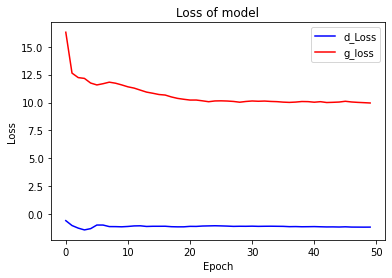

In [11]:
val.make_loss_curve(
    loss_file,
    file_type
)

In [12]:
g_path = "../model/threat/cifar10/g_70.pth"
ec_path = "../model/threat/cifar10/ec_70.pth"
choose = "test"

In [13]:
g_model.load_state_dict(torch.load(g_path))
ec_model.load_state_dict(torch.load(ec_path))

<All keys matched successfully>

In [14]:
gen_py3.threat_attack(
    g_model,
    ec_model,
    data_set,
    choose
    )

-test set start-
count:10000/10000,cost:0.021096s
test set cost:100.97957659s
saving...
-complete-


In [15]:
import tst

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #network architecture
        self.conv_layer = nn.Sequential(
            # Conv Layer Block 1: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3),  # 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3),  # 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 16

            # Conv Layer Block 2: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),  # 16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 8
            #     nn.Dropout2d(p=0.05),

            # Conv Layer Block 3: conv-bn-relu-conv-bn-relu-pool
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)   # 4
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            #     nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [17]:
t_model = CNN()

In [18]:
test_model="../../target/cifar10/CNN.pt"
t_model.load_state_dict(torch.load(test_model))

<All keys matched successfully>

In [19]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape)
tst.robustness_test(
    model = t_model,
    adv_sample_path = '../sample/THREAT_cifar10/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:87.990000%


In [20]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y
    
    # function to extact the multiple features
    def feature_list(self, x):
        out_list = []
        out = F.relu(self.bn1(self.conv1(x)))
        out_list.append(out)
        out = self.layer1(out)
        out_list.append(out)
        out = self.layer2(out)
        out_list.append(out)
        out = self.layer3(out)
        out_list.append(out)
        out = self.layer4(out)
        out_list.append(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y, out_list
    
    # function to extact a specific feature
    def intermediate_forward(self, x, layer_index):
        out = F.relu(self.bn1(self.conv1(x)))
        if layer_index == 1:
            out = self.layer1(out)
        elif layer_index == 2:
            out = self.layer1(out)
            out = self.layer2(out)
        elif layer_index == 3:
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
        elif layer_index == 4:
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)               
        return out

    # function to extact the penultimate features
    def penultimate_forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        penultimate = self.layer4(out)
        out = F.avg_pool2d(penultimate, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y, penultimate

def ResNet9():
    return ResNet(BasicBlock, [1,1,1,1], num_classes=10)
    
def ResNet18():
    return ResNet(PreActBlock, [2,2,2,2], num_classes=10)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3], num_classes=10)

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3], num_classes=10)

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3], num_classes=10)

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3], num_classes=10)

In [21]:
t_model = ResNet9()

In [22]:
test_model="../../target/cifar10/ResNet9.pt"
t_model.load_state_dict(torch.load(test_model))

<All keys matched successfully>

In [23]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape)
tst.robustness_test(
    model = t_model,
    adv_sample_path = '../sample/THREAT_cifar10/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:75.150000%


In [24]:
t_model = ResNet34()

In [25]:
test_model="../../target/cifar10/ResNet34.pt"
t_model.load_state_dict(torch.load(test_model))

<All keys matched successfully>

In [26]:
tst.robustness_test(
    model = t_model,
    adv_sample_path = '../sample/THREAT_cifar10/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:76.350000%
